# 边界条件和约化系统

注意，本节需要的编程量相对前几节较大。

我们已经建立了总体刚度矩阵并联系起总体有限元系统
$$
KA=F
$$
所以我们一定希望现在就来求解这一线性系统获得各节点的位移，检验我们是否已经实现了一个有限元程序。但不幸的是，有限元程序到这里并未结束，因为刚度矩阵是不可逆的。

刚度矩阵的不可逆性有着明确的物理含义，弹性体发生一个刚体位移（rigid deformation），节点力不变，但反之不行，即
$$
KA=F\\
K(A+A^{rd})=F'\\
F=F'
$$

在平面问题中，刚体位移包括x轴平移、y轴平移和面内旋转三个自由度（在空间问题中为三个平移和三个旋转，共六个），所以我们需要至少要为有限元系统提供三个约束。最简单的约束是固定节点位移，此外可以添加补充方程（例如弹性支座、周期条件等）。

从另一个角度看，微分方程的定解问题包括柯西问题（初值）和边值问题，由于我们现在考虑静态结构，不存在柯西问题，所以我们看边值问题。边值问题的描述包括 Dirichlet 边界条件（位移边界条件）和 Neumann 边界条件（力边界条件）。这些边界条件影响着有限元实际问题的最终计算结果。通过上述关于总体系统的讨论，我们知道一个弹性有限元问题至少包括减少三个刚体位移自由度的 Dirichlet 边界条件，而 Neumann 边界条件是任意的。

对于有限元问题
$$
KA=F
$$
简单起见，我们首先研究完全固定而非补充方程。考虑一 Dirichlet 边界条件，它影响 $A$ 中若干自由度，这些自由度是固定的（fixed），它们的编号为 $\{i_f\}$ ，则剩余的自由度为 $\{i_r\}$ ，下标 r 指约化系统（reduced system）。定义按行约化量
$$
A^r=[A(i_r)],\quad i_r\in \{i_r\}
$$
$$
K^{rc}=[K(i_r,:)],\quad i_r\in \{i_r\}
$$
删除编号为 $\{i_f\}$ 的自由度，可以得到
$$
K^{rc}A^r=F
$$

下面出于两点考虑，我们继续按列约化。第一点是从数学上，上述方程的秩只为约化系统的自由度 $\mathrm{len}(i_r)$ ，所以该线性系统是超定的，我们只能选取其中 $\mathrm{len}(i_r)$ 个方程求解。第二点即选择哪些方程，首先按照方程数目我们自然想到求解那些自由的节点自由度上的方程，即右边是 $F(i_r)$ 的方程。这在力学上也是合理的，因为这些节点的力是未知的，而其他节点的力要么是 0 （无边界条件和体力），要么是 Neumann 边界条件或体力给定值。定义按行约化量
$$
F^r=[A(i_r)],\quad i_r\in \{i_r\}
$$
$$
K^r=[K^{rc}(:,i_r)]=[K(i_r,j_r)],\quad i_r,j_r\in \{i_r\}
$$
我们可以写出约化系统的有限元方程
$$
K^r A^r=F^r
$$
若边界条件是恰当的，则该方程是满秩的。

接下来我们实现约化系统，这里的难点在于怎样设计数据的储存方式。更进一步讲，这里就要考试考虑如何让我们的程序更好操作。我们早已讲过，经典有限元理论和算法完全定型的当下，一个现代有限元程序的成功关键在于它是好用的。

In [1]:
import numpy as np
import pygmsh
with pygmsh.geo.Geometry() as geom:
    geom.add_polygon([[0.0, 0.0],[1.0, 0.0],[1.0, 1.0],[0.0, 1.0],],mesh_size=0.5,)
    mesh = geom.generate_mesh()
nodes=mesh.points
elements=mesh.cells_dict['triangle']

首先将前几节内容汇总

In [2]:
E=10.0
nv=0.3
D=E/(1.0-nv**2)*np.array([
    [1.0,nv,0.0], 
    [nv,1.0,0.0], 
    [0.0,0.0,0.5*(1.0-nv)]])

len_global=2*len(nodes)
K=np.zeros((len_global,len_global))

for element in elements:
    x0=nodes[element[0]][0]
    y0=nodes[element[0]][1]
    x1=nodes[element[1]][0]
    y1=nodes[element[1]][1]
    x2=nodes[element[2]][0]
    y2=nodes[element[2]][1]
    area_2=np.linalg.det(np.array([
        [1.0,x0,y0], 
        [1.0,x1,y1], 
        [1.0,x2,y2]]))
    B=0.5/area_2*np.array([
        [y1-y2,0.0,y2-y0,0.0,y0-y1,0.0], 
        [0.0,x2-x1,0.0,x0-x2,0.0,x1-x0], 
        [x2-x1,y1-y2,x0-x2,y2-y0,x1-x0,y0-y1]])
    K_element=area_2*B.T@D@B
    deform_global_index=np.array([[2*element[i],2*element[i]+1] for i in range(3)],dtype=np.uint64).reshape(-1)
    for i_local,i_global in enumerate(deform_global_index):
        for j_local,j_global in enumerate(deform_global_index):
            K[i_global,j_global]+=K_element[i_local,j_local]

可以测试一下总体刚度矩阵的秩

In [3]:
rank=np.linalg.matrix_rank(K)
print(f'K is {len_global}-order matrix, and its rank is {rank}')

K is 24-order matrix, and its rank is 21


这里我们选择建立边界条件字典，其具体设计必将考虑各种复杂的边界条件描述，我们先做一个简易版，包括x轴位移、y轴位移和节点力。其索引为节点编号。

首先看一下网格上的节点标号：

Text(0.5, 1.0, 'Mesh')

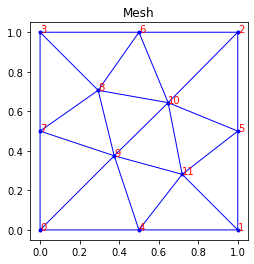

In [4]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
x=mesh.points.T[0]
y=mesh.points.T[1]
elements=mesh.cells_dict['triangle']
mesh_fig=tri.Triangulation(x,y,elements)
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(mesh_fig,'b.-',lw=1)
for index,_ in enumerate(nodes):
    plt.annotate(index,(x[index],y[index]),color="red")
plt.title('Mesh')

我们完全固定最左侧节点的两个自由度，右侧中点赋予 1.0 的水平拉力。其字典形式即

In [5]:
x_fix={0:0.0,2:0.0,3:0.0}
y_fix={0:0.0,2:0.0,3:0.0}
f_given={5:(1.0,0.0)}

首先生成一个总体系统的节点位移 $A$ 和节点力数组 $F$ ，然后将边界条件数据填入其中。在约化系统计算中，不需要也不应更改这两个数组。在约化系统计算结束后，再更新这两个数组。

In [6]:
deform=np.zeros(len_global)
force=np.zeros(len_global)
for node in x_fix:
    deform[2*node]=x_fix[node]
for node in y_fix:
    deform[2*node+1]=y_fix[node]
for node in f_given:
    force[2*node]=f_given[node][0]
    force[2*node+1]=f_given[node][1]

将未固定唯一自由度的节点的位置，即约化系统的变量在总体系统中的指标，记录在 $\{i_r\}$ （deform_free_index）中。

In [7]:
deform_free_index=[]
for node,_ in enumerate(nodes):
    if node not in x_fix:
        deform_free_index.append(2*node)
    if node not in y_fix:
        deform_free_index.append(2*node+1)
len_reduce=len(deform_free_index)

建立约化系统中的节点位移 $A^r$ 和节点力数组 $F^r$ ，其中结点位移数组将会在线性系统求解时更新；节点力系统需要将力边界条件（总体节点力）中的数据填入其中，其他位置为零。

In [8]:
deform_reduce=np.empty(len_reduce)
force_reduce=np.zeros(len_reduce)
for i_reduce,i_global in enumerate(deform_free_index):
    force_reduce[i_reduce]=force[i_global]

最后建立约化刚度矩阵 $K^r$

In [9]:
K_reduce=np.zeros((len_reduce,len_reduce))
for i_reduce,i_global in enumerate(deform_free_index):
    for j_reduce,j_global in enumerate(deform_free_index):
        K_reduce[i_reduce,j_reduce]=K[i_global,j_global]

我们检验约化刚度矩阵的秩

In [10]:
rank=np.linalg.matrix_rank(K_reduce)
print(f'K^r is {len_reduce}-order matrix, and its rank is {rank}')

K^r is 18-order matrix, and its rank is 18


终于，我们建立了约化系统的有限元方程
$$
K^r A^r=F^r
$$
现在求解线性系统

In [11]:
deform_reduce=np.linalg.solve(K_reduce,force_reduce)
print(f'A^r = \n{deform_reduce}')

A^r = 
[ 0.14444686 -0.03193487  0.13191981  0.01890696  0.34240188  0.00689897
  0.07921049 -0.04799564  0.13794975 -0.01279628  0.11225761 -0.01757941
  0.14459907 -0.02217255  0.17882954 -0.05162197  0.21508163  0.00613928]


**这就是胜利的曙光。**

传统上的计算密集区，但是已经相当成熟，不需要我们花心思优化。

下面的任务我们终于可以有底气地进行了。更新总体节点数据。首先将约化系统的结点位移 $A^r$ 填回总体系统的结点位移 $A$

In [12]:
for i_reduce,i_global in enumerate(deform_free_index):
    deform[i_global]=deform_reduce[i_reduce]

再重新计算节点力 $F$ 

In [13]:
force=K@deform
print(f'force = \n{force}')

force = 
[-3.83456789e-01 -8.80975205e-02 -8.32667268e-17  3.98986399e-17
 -2.81881849e-01 -1.16543211e-01 -3.34661362e-01  2.04640731e-01
 -1.11022302e-16  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -4.16333634e-17 -9.71445147e-17  1.66533454e-16 -2.77555756e-17
  2.22044605e-16  5.55111512e-17 -3.33066907e-16 -1.24900090e-16
 -2.22044605e-16 -1.11022302e-16  3.88578059e-16 -1.94289029e-16]
